# Makemore Part 5: building wavenet

In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
words = open('../data/names.txt', 'r').read().splitlines()

In [15]:
# build vocab of characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [16]:
# building the dataset
block_size = 3
def build_dataset(words):
    
    X,Y = [],[]
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

In [17]:
# train, val and test splits:
import random
random.seed(42)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [18]:
print(Xtr.shape, Xval.shape, Xtest.shape)

torch.Size([182778, 3]) torch.Size([22633, 3]) torch.Size([22735, 3])


In [19]:

# ----------------------------------- Linear Layer -----------------------------------
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [20]:
# ----------------------------------- Batch Norm Layer -----------------------------------
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (training with running 'momentum update': mean and std)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        # if we 're training, we calculate mean and std of the batch
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True) # calculate variance because we want to add epsilon(error term) to it to calculate our preactivations
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta # gamma: gain, beta: bias
        
        # update buffers if training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta] # Note: we don't add buffers here as we don't want to train them. They are updated internally in forward pass and not with gradients

In [21]:
# ----------------------------------- Tanh Layer -----------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

## Creating Modules for Embedding and flattening operations


In [34]:
# ----------------------------------- Embedding Layer -----------------------------------
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, Ix):
        self.out = self.weight[Ix]
        return self.out
    
    def parameters(self):
        return [self.weight]

In [35]:
# ----------------------------------- Flatten Layer -----------------------------------
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

In [22]:
# set torch seed 
torch.manual_seed(42)

# Simplifying our layers
- Docs: https://docs.pytorch.org/docs/stable/nn.html#containers
- Types of containers:
    - Module
    - Sequential
        - A sequential container. Modules will be added to it in the order they are passed in the constructor. Alternatively, an OrderedDict of modules can be passed in. The forward() method of Sequential accepts any input and forwards it to the first module it contains. It then “chains” outputs to inputs sequentially for each subsequent module, finally returning the output of the last module.
    - ModuleList
    - ModuleDict
    - ParameterList
    - ParameterDict
- We can use something called containers in pytorch
- We can use the Sequential container in pytorch to build out a sequence of Linear layers here

In [37]:
# ----------------------------------- Sequential Container -----------------------------------
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [46]:
n_embed = 10
n_hidden = 200
vocab_size = 27
block_size = 3

model = Sequential([
    Embedding(vocab_size, n_embed),
    Flatten(),
    Linear(n_embed*block_size,n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# weight adjustment for last layer
with torch.no_grad():
    model.layers[-1].weight*=0.1
    
# paramater initialization
parameters = model.parameters()
for p in parameters:
    p.requires_grad = True
    
print(f'number of parameters: {sum(p.nelement() for p in parameters)}')    

number of parameters: 12097


In [47]:
max_steps = 200000
batch_size = 32
losses = []
ud = []

In [48]:
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, batch Y
    
    
    # forward pass
    logits = model(Xb)
    ## No longer need to loop through layers, we can simply call model(Xb) for forward pass now. Similar to pytorch nn.Sequential
    # x = Xb
    # for layer in layers:
    #     x = layer(x)
    loss = F.cross_entropy(logits, Yb)
    
    # --- backward pass ---
    for p in parameters:
        p.grad = None
    loss.backward()
   
    # --- LR update schedule ---
    lr  = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data+= -lr*p.grad
    
    # --- track stats ---
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())


      0/ 200000: 3.2790
  10000/ 200000: 2.4084
  20000/ 200000: 2.1853
  30000/ 200000: 1.9445
  40000/ 200000: 2.1591
  50000/ 200000: 1.7867
  60000/ 200000: 2.2200
  70000/ 200000: 2.0056
  80000/ 200000: 2.0890
  90000/ 200000: 2.2263
 100000/ 200000: 2.2635
 110000/ 200000: 2.1835
 120000/ 200000: 2.7047
 130000/ 200000: 1.9718
 140000/ 200000: 1.9659
 150000/ 200000: 2.4042
 160000/ 200000: 1.8647
 170000/ 200000: 2.1023
 180000/ 200000: 2.5041
 190000/ 200000: 2.1514


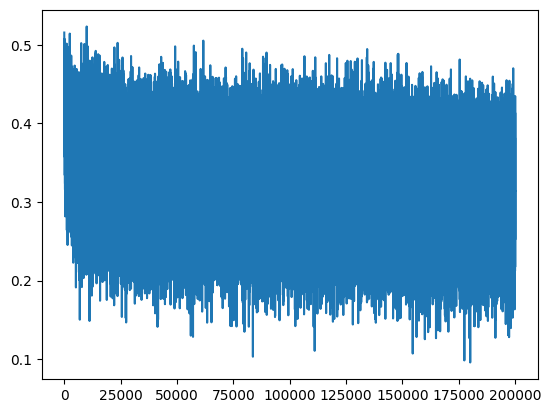

In [49]:
plt.plot(losses)

The plot above isn't super informative. We can plot avgs per 1000 iterations and see the loss curve

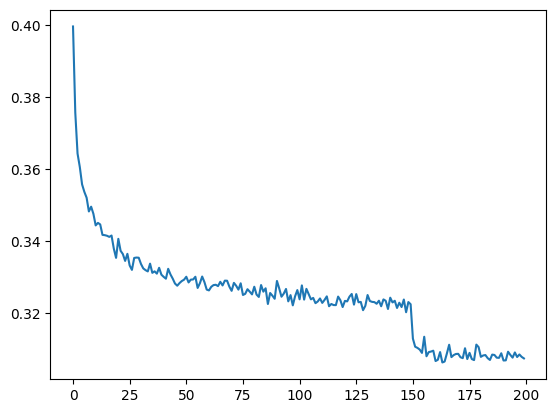

In [50]:
plt.plot(torch.tensor(losses).view(-1,1000).mean(1))

In [51]:
# Set layers to eval mode for inference
for layer in model.layers:
    layer.training = False 

In [52]:
@torch.no_grad()
def split_loss(split:str)-> None:
    X,y = {
        'train':(Xtr,Ytr),
        'val':(Xval,Yval),
        'test':(Xtest,Ytest)
    }[split]
    # emb = C[X]
    # x = emb.view(emb.shape[0],-1)
    # for layer in layers:
    #     x = layer(x)
    logits = model(X)
    loss = F.cross_entropy(logits,y)
    print(f'{split} loss: {loss.item():.4f}')
split_loss('train')
split_loss('val')
    

train loss: 2.0124
val loss: 2.3223


In [53]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      # emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      # x = emb.view(emb.shape[0], -1) # concatenate the vectors

      # for layer in layers:
      #   x = layer(x)
      # logits = x
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmah.
amorilvi.
kimrix.
taty.
salaysie.
rahnee.
den.
rhy.
kaeli.
nellara.
chaiiv.
kaleigh.
ham.
joce.
quintis.
lilea.
jadiquintero.
dearynn.
jace.
pinsley.


# Building Wavenet
**Wavenet Paper: https://arxiv.org/pdf/1609.03499**
- Processing inputs as : 

![Wavenet Image Processing](../plots/wavenet-input-character-processing.png)

In [55]:
# building the dataset
block_size = 8 # expanding our context window
def build_dataset(words:list[str])->tuple[torch.Tensor,torch.Tensor]:
    """_summary_

    Args:
        words (list[str]): List of words

    Returns:
        tuple[torch.Tensor,torch.Tensor]: Data set with X as the context and Y as the target
    """
    X,Y = [],[]
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

In [56]:
# train, val and test splits:
import random
random.seed(42)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [57]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[i.item()] for i in x), '->', itos[y.item()])

........ -> e
.......e -> m
......em -> m
.....emm -> a
....emma -> .
........ -> o
.......o -> l
......ol -> i
.....oli -> v
....oliv -> i
...olivi -> a
..olivia -> .
........ -> a
.......a -> v
......av -> a
.....ava -> .
........ -> i
.......i -> s
......is -> a
.....isa -> b


In [76]:
# ----------------------------------- Modified Flatten Layer -----------------------------------
## This flatten layer now expects a value for how many characters you want consecutively called n_consecutive
class FlattenConsecutive:
    def __init__(self, n_consecutive:int):
        self.n_consecutive = n_consecutive
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n_consecutive, self.n_consecutive*C) # using T//self.n_consecutive instead of -1 to be more explicit
        if x.shape[1]==1:
            x = x.squeeze(1) # if we have only one character, we can just squeeze the dimension
        self.out=x
        return self.out
    
    def parameters(self):
        return []

In [83]:
# ----------------------------------- Modified Batch Norm Layer -----------------------------------
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers (training with running 'momentum update': mean and std)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        # if we 're training, we calculate mean and std of the batch
        # Adding ability to reduce over multiple dimensions
        # Departs from Pytorch's BatchNorm1d implementation (N, C) or (N, C, L), where pytorch assumes C is the 1st dimension. We assume C is the last dimension
        if x.ndim==2:
            dim = 0
        elif x.ndim==3:
            dim = (0,1)
        else:
            raise ValueError(f"BatchNorm1d expects 2D or 3D input, but got {x.ndim}D input")
        if self.training:
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True) # calculate variance because we want to add epsilon(error term) to it to calculate our preactivations
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta # gamma: gain, beta: bias
        
        # update buffers if training
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta] # Note: we don't add buffers here as we don't want to train them. They are updated internally in forward pass and not with gradients

In [101]:
n_embed = 24
n_hidden = 128 # checking if we 're using all cells efficiently
vocab_size = 27
block_size = 8
n_consecutive = 2

model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(n_consecutive=n_consecutive),Linear(n_embed*n_consecutive,n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n_consecutive=n_consecutive),Linear(n_hidden*n_consecutive,n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(n_consecutive=n_consecutive),Linear(n_hidden*n_consecutive,n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# weight adjustment for last layer
with torch.no_grad():
    model.layers[-1].weight*=0.1
    
# paramater initialization
parameters = model.parameters()
for p in parameters:
    p.requires_grad = True
    
print(f'number of parameters: {sum(p.nelement() for p in parameters)}')    

number of parameters: 76579


In [85]:
# ix = torch.randint(0, Xtr.shape[0],(4,))
# Xb, Yb = Xtr[ix], Ytr[ix]
# logits = model(Xb)
# print(Xb.shape)
# Xb

In [102]:
max_steps = 200000
batch_size = 32
losses = []

In [103]:
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, batch Y
    
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    # --- backward pass ---
    for p in parameters:
        p.grad = None
    loss.backward()
   
    # --- LR update schedule ---
    lr  = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data+= -lr*p.grad
    
    # --- track stats ---
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    losses.append(loss.log10().item())
    

      0/ 200000: 3.2891
  10000/ 200000: 2.4133
  20000/ 200000: 1.9306
  30000/ 200000: 2.2376
  40000/ 200000: 1.8352
  50000/ 200000: 2.1842
  60000/ 200000: 1.7624
  70000/ 200000: 1.7863
  80000/ 200000: 1.9613
  90000/ 200000: 1.9515
 100000/ 200000: 1.9888
 110000/ 200000: 1.8232
 120000/ 200000: 2.3805
 130000/ 200000: 2.1072
 140000/ 200000: 1.8101
 150000/ 200000: 1.9345
 160000/ 200000: 1.9555
 170000/ 200000: 1.7104
 180000/ 200000: 2.0974
 190000/ 200000: 1.8547


In [104]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


In [94]:
model.layers[3].running_mean.shape # correct shape for running mean after update

torch.Size([1, 1, 128])

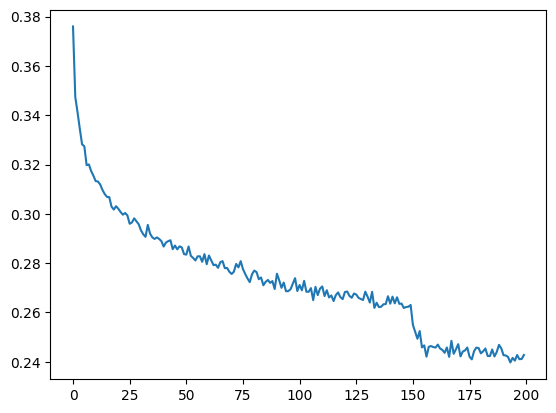

In [105]:
plt.plot(torch.tensor(losses).view(-1,1000).mean(1))

In [107]:
for layer in model.layers:
    layer.training = False

In [108]:
split_loss('train'), split_loss('val')

train loss: 1.7249
val loss: 2.2488


(None, None)